**Genomics_ood Classification Network**

Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

Custom Layer Class

In [2]:
class MyDense(tf.keras.layers.Layer):
  """
  Our own custom layer function, which inherits from the keras.layers.Layer class

    Functions:
      init: constructor
      call: calculates output tensor for this layer
      build: creates weights and bias when call is the first time run
  """

  def __init__(self, units, activation=tf.nn.softmax):
    """
    Constructs an fully connected layer.

      Args:
        units: perceptrons of our layer
        activation: activation function of our layer
    """

    super(MyDense, self).__init__()

    self.units = units
    self.activation = activation


  def call(self, inputs):
    """
    Calculates the output of our layer. (forwads_step)

      Args:
        inputs: input tensor of our layer

      Returns:
        x: the output of our layer
    """

    x = tf.matmul(inputs, self.w) + self.b
    x = self.activation(x)

    return x


  def build(self,input_shape):
    """
    Creates random weights and bias from a normal distribution for our layer.

      Args:
        input_shape: dimension of our input-tensor
    """

    self.w = self.add_weight(shape=(input_shape[-1],self.units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                            initializer='random_normal',
                            trainable=True)




Custom Model Class

In [4]:
class MyModel(tf.keras.Model):
  """ 
  Our own custon MLP model, which inherits from the keras.Model class

    Functions:
      init: constructor of our model
      call: performs forward pass of our model
  """
  def __init__(self):
    """
    Constructs our MLP model with three fully connected layers.
    """

    super(MyModel, self).__init__()

    # two hidden layers with each 256 perceptrons and sigmoid as activation function
    self.dense_h1 = MyDense(256, activation=tf.nn.sigmoid)
    self.dense_h2 = MyDense(256, activation=tf.nn.sigmoid)

    # our output layer with 10 perceptrons (our output categories) and softmax activation
    self.dense_o = MyDense(10, activation=tf.nn.softmax)

  def call(self, inputs):
    """
    Performs a forward step in our MLP

      Args:
        inputs: our preprocessed input data, we send through our model
      Results:
        output: the predicted output of our input data
    """
    # first hidden layer
    x = self.dense_h1(inputs)

    # second hidden layer
    x = self.dense_h2(x)
    
    # output layer
    output = self.dense_o(x)

    return output


Train Function

In [5]:
@tf.function
def train_step(model, input, target, loss_function, optimizer):
  """
  Performs a forward and backward pass for  one dataponit of our training set

    Parameters:
      model: our created MLP model
      input:
      target:
      loss_funcion: function we used for calculating our loss
      optimizer: our optimizer used for packpropagation
    Results:
      loss: our calculated loss for the datapoint
  """
  
  with tf.GradientTape() as tape:

    # forward step
    prediction = model(input)

    # calculating loss
    loss = loss_function(target, prediction)

    # calculaing the gradients
    gradients = tape.gradient(loss, model.trainable_variables)

  # updating weights and biases  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss

Test Function

In [6]:
def test(model, test_data, loss_function):
  """
  Test our MLP, by going through our testing dataset, 
  performing a forward pass and calculating loss and accuracy

    Parameters:
      model: our created MLP model
      test_data: our preprocessed test dataset
      loss_funcion: function we used for calculating our loss
    Results:

        
  """
  # initializing lists for accuracys and loss
  accuracy_aggregator = []
  loss_aggregator = []

  for (input, target) in test_data:

    # forward step
    prediction = model(input)

    # calculating loss
    loss = loss_function(target, prediction)

    # calculating accuracy
    accuracy =  np.argmax(target.numpy(), axis=1) == np.argmax(prediction.numpy(), axis=1)
    accuracy = np.mean(accuracy)

    # add loss and accuracy to the lists
    loss_aggregator.append(loss.numpy())
    accuracy_aggregator.append(np.mean(accuracy))

  # calculate the mean of the loss and accuracy (for this epoch)
  loss = tf.reduce_mean(loss_aggregator)
  accuracy = tf.reduce_mean(accuracy_aggregator)
  
  return loss, accuracy

Preprocessing Functions

In [7]:

@tf.function()
def one_hot_encode(categories,input):
  """
  Creates an one_hot-tensor from our byte-string input.
    Parameters: 
              categories = categories of our input for one hot encoding 
              input = tf.string, which we want to encode
  """

  # split the tensor containing the genome sequence into a list of tensors,
  # each containing one character from the original sequence
  splitted = tf.strings.bytes_split(input)
  reshaped = tf.reshape(splitted,(250,))
  iterable_tensors = tf.unstack(reshaped)

  encoded_input = []

  # iterate over the list of single character
  for data in iterable_tensors:

    # for each category: 
    # if the character equals that category append 1 and 0 otherwise
    encoded_input.extend([int(data==category) for category in categories])
    
  return encoded_input

def prepare_data(ds):
  """
  Preparing our data for our model.
    Parameters:
      ds: the dataset we want to preprocess
    Returns:
      ds: preprocessed dataset
  """

  # one hot encode the features and targets
  ds = ds.map(lambda feature, target: (one_hot_encode(["A","C","G","T"],feature), tf.one_hot(target,10)))

  # cast features and targets to float32
  ds = ds.map(lambda feature, target: (tf.cast(feature, tf.float32),tf.cast(target,tf.float32)))

  # cache the elements
  ds = ds.cache()

  # shuffle, batch, prefetch our dataset
  ds = ds.shuffle(5000)
  ds = ds.batch(32)
  ds = ds.prefetch(20)
  
  return ds

Loading and preprocessing the data

In [8]:
# load data from the genomics_odd dataset; 100.000 samples from the train set and 1000 from the test set
train_ds, test_ds = tfds.load('genomics_ood',split = ['train[:100000]','test[:1000]'], shuffle_files = True, as_supervised = True)

# preprocess our data
train_ds = train_ds.apply(prepare_data)
test_ds = test_ds.apply(prepare_data)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/12 [00:00<?, ? file/s]


Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


Training and testing our model

In [10]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

# Testing on our test_ds once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Testing on our train_ds once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# Training our modelfor num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # training (and calculating loss while training)
    epoch_loss_agg = []
    for input,target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # testing our model in each epoch to track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.1015625
Epoch: 1 starting with accuracy 0.337890625
Epoch: 2 starting with accuracy 0.3798828125
Epoch: 3 starting with accuracy 0.35546875
Epoch: 4 starting with accuracy 0.376953125
Epoch: 5 starting with accuracy 0.3701171875
Epoch: 6 starting with accuracy 0.375
Epoch: 7 starting with accuracy 0.376953125
Epoch: 8 starting with accuracy 0.3798828125
Epoch: 9 starting with accuracy 0.3544921875


Visualizing losses and accuracy

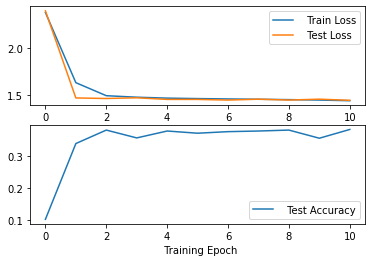

In [11]:
def visualize(train_loss,test_loss,accuracy):
  """
  Displays training and testing loss as well as accuracy per epoch each in a line plot.

    Args:
      train_loss = mean training loss per epoch 
      test_loss = mean testing loss per epoch
      accuracy = mean accuracy (testing dataset) per epoch
  """

  fig, axes = plt.subplots(2)
  line_1 = axes[0].plot(train_loss,label="  Train Loss")
  line_2 = axes[0].plot(test_loss, label = "  Test Loss")
  line_3 = axes[1].plot(accuracy, label = "  Test Accuracy")
  plt.xlabel("  Training Epoch")
  axes[0].legend()
  axes[1].legend()
  plt.show
visualize(train_losses,test_losses,test_accuracies)